In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

In [2]:
from refer import REFER
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import os
from PIL import Image as PImage # pillow

## Load COCO dataset

In [3]:
data_root = 'coco'  # contains refclef, refcoco, refcoco+, refcocog and images
dataset = 'refcoco' 
splitBy = 'unc'
refer = REFER(data_root, dataset, splitBy)

loading dataset refcoco into memory...
creating index...
index created.
DONE (t=5.76s)


In [4]:
ref_id = 35254
ref = refer.Refs[ref_id]
ref

{'sent_ids': [100272, 100273, 100274],
 'file_name': 'COCO_train2014_000000173056_1.jpg',
 'ann_id': 275551,
 'ref_id': 35254,
 'image_id': 173056,
 'split': 'train',
 'sentences': [{'tokens': ['white', 'brown', 'sheep', 'right'],
   'raw': 'white brown sheep right',
   'sent_id': 100272,
   'sent': 'white brown sheep right'},
  {'tokens': ['black', 'sheep', 'on', 'right'],
   'raw': 'black sheep on right',
   'sent_id': 100273,
   'sent': 'black sheep on right'},
  {'tokens': ['sheep', 'on', 'the', 'right'],
   'raw': 'sheep on the right',
   'sent_id': 100274,
   'sent': 'sheep on the right'}],
 'category_id': 20}

In [5]:
def get_bounded_subimage(img_id, ann_id, xs=224,ys=224, show=False):
    
    bbox = refer.Anns[ann_id]['bbox']
    bbox = [int(b) for b in bbox]
    img = refer.Imgs[img_id]
   
    I = io.imread(os.path.join(refer.IMAGE_DIR, img['file_name']))
    sub = I[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
    if show:
        plt.figure()
        ax = plt.gca()
        ax.imshow(sub)
        plt.show()
    
    if len(sub) == 0: return None
    pim = PImage.fromarray(sub)
    pim2 = pim.resize((xs,ys), PImage.Resampling.LANCZOS)
    img = np.array(pim2)
    
    if len(img.shape) < 3: return None
    
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    
    return pim2, img, bbox

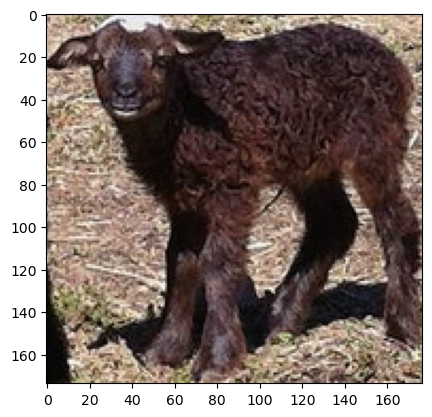

In [6]:
pim , img, bbox = get_bounded_subimage(ref['image_id'], ref['ann_id'], show=True)

In [7]:
img

array([[[[201, 175, 155],
         [214, 191, 170],
         [209, 188, 168],
         ...,
         [219, 192, 174],
         [197, 170, 150],
         [184, 157, 135]],

        [[197, 172, 151],
         [214, 192, 171],
         [220, 199, 179],
         ...,
         [202, 175, 156],
         [185, 158, 139],
         [182, 155, 136]],

        [[170, 145, 128],
         [165, 141, 125],
         [193, 169, 154],
         ...,
         [193, 165, 146],
         [206, 179, 159],
         [224, 198, 178]],

        ...,

        [[  4,   4,   5],
         [  7,   7,   8],
         [  8,   8,   7],
         ...,
         [115, 104,  98],
         [117, 104,  90],
         [145, 132, 117]],

        [[  6,   7,   6],
         [  8,   9,   8],
         [  9,   9,   8],
         ...,
         [228, 209, 195],
         [189, 172, 159],
         [144, 129, 116]],

        [[  9,   9,   9],
         [  9,   9,   9],
         [ 11,  11,  10],
         ...,
         [193, 172, 160],
        

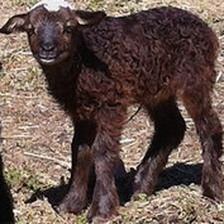

In [8]:
pim

## Load librarbies and helper function for SAM (Segment Anything)

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

## Load vit-h model checkpoint from SAM 

In [11]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

/home/itadmin/anaconda3/envs/A8/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Full Image test

In [12]:
image = cv2.imread('coco/images/mscoco/images/train2014/COCO_train2014_000000173056.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

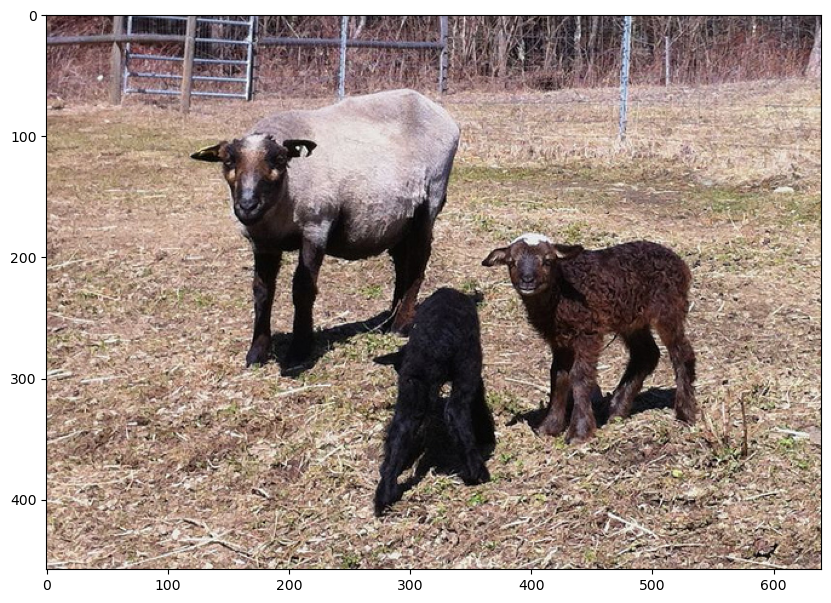

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [14]:
predictor.set_image(image)

In [15]:
#'bbox': [x_min, y_min, width, height]
bbox

[360, 182, 177, 174]

In [16]:
x = (bbox[0] + (bbox[2]/2))
y = (bbox[1] + (bbox[3]/2))
x, y

(448.5, 269.0)

In [17]:
input_point = np.array([[x, y]])
input_label = np.array([1])
input_box = np.array([bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]) #xyxy format

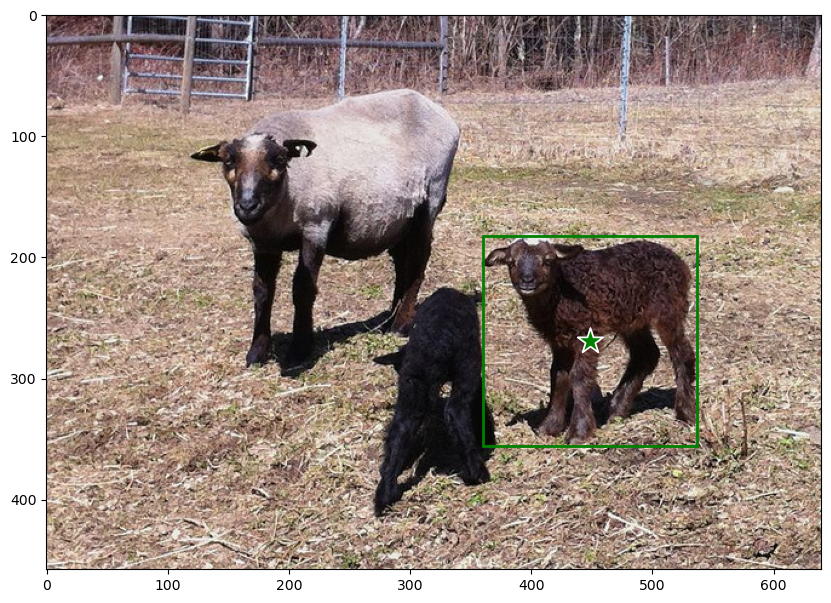

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
show_box(input_box, plt.gca())
plt.axis('on')
plt.show() 

In [19]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

In [20]:
masks.shape  # (number_of_masks) x H x W

(1, 458, 640)

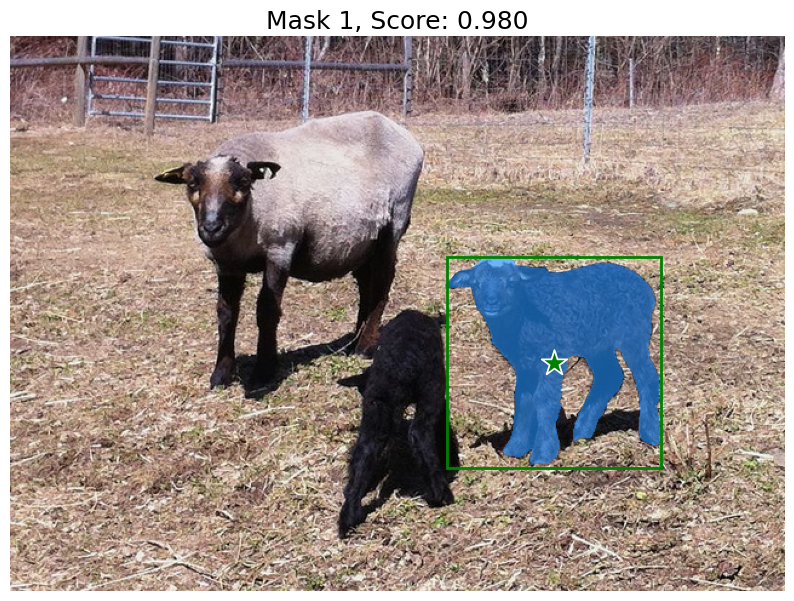

In [21]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    show_box(input_box, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

In [ ]:
masks

In [ ]:
logits

In [ ]:
scores

In [22]:
image[~mask,:] = [255,255,255]

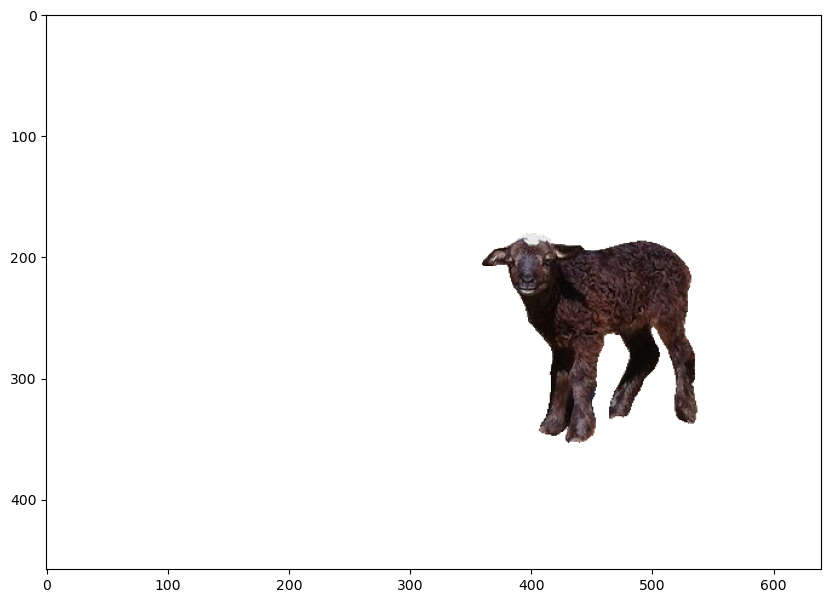

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
#best_mask = logits[np.argmax(scores), :, :]
#best_mask

In [ ]:
#best_mask.shape

## Small Image Test

In [24]:
image = cv2.imread('coco/images/mscoco/images/train2014/COCO_train2014_000000173056.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [25]:
s_image = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]] 

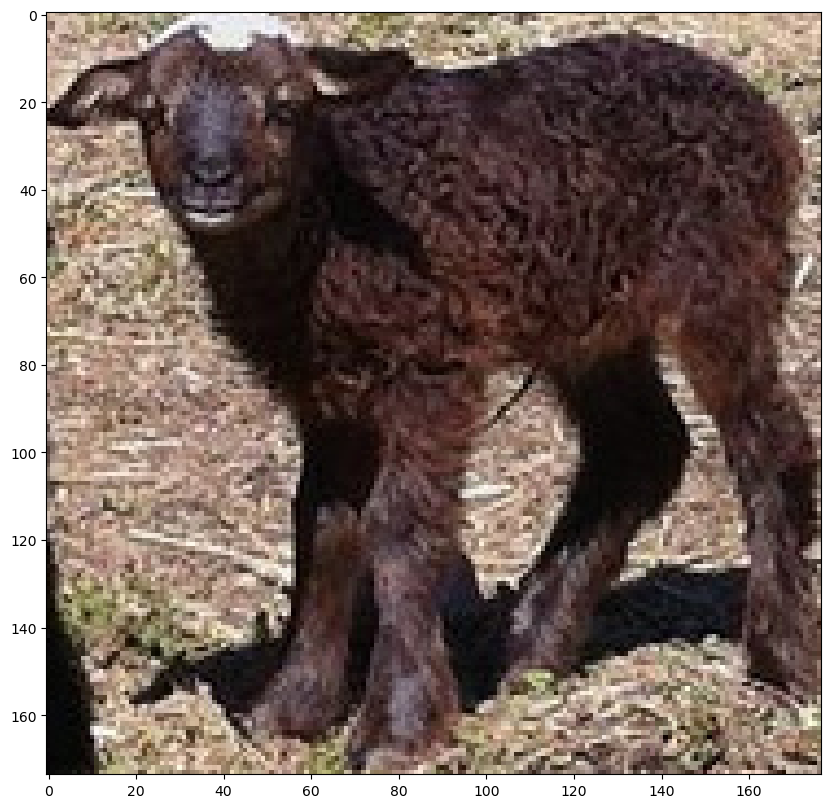

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(s_image)
plt.axis('on')
plt.show()

In [27]:
predictor.set_image(s_image)

In [28]:
s_image.shape

(174, 177, 3)

In [29]:
x = s_image.shape[1]/2
y = s_image.shape[0]/2
x, y

(88.5, 87.0)

In [30]:
input_point = np.array([[x, y]])
input_label = np.array([1])

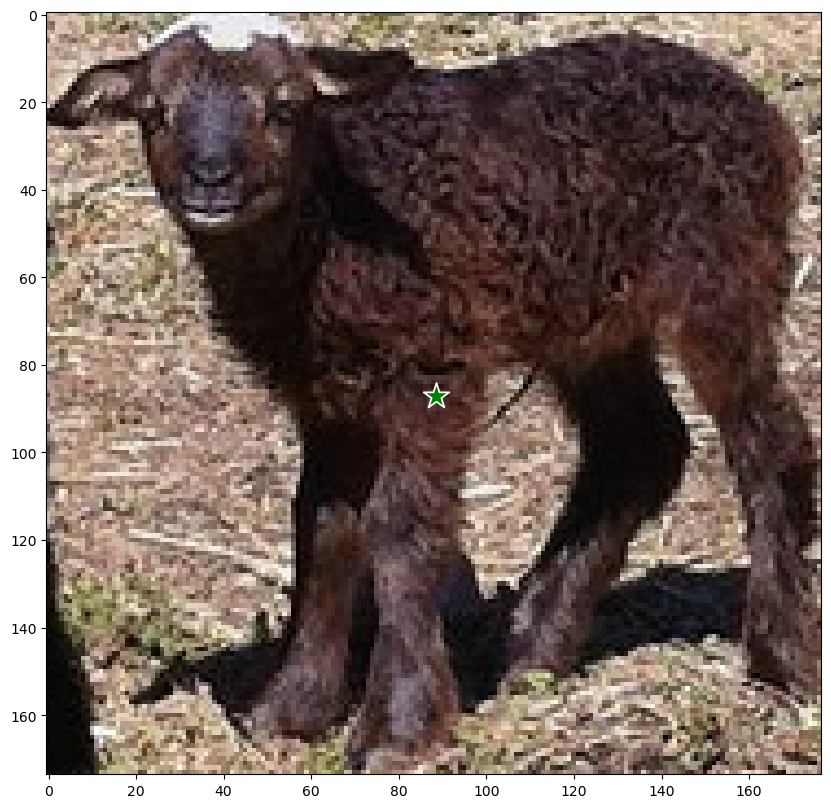

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(s_image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show() 

In [32]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

In [33]:
masks.shape  # (number_of_masks) x H x W

(1, 174, 177)

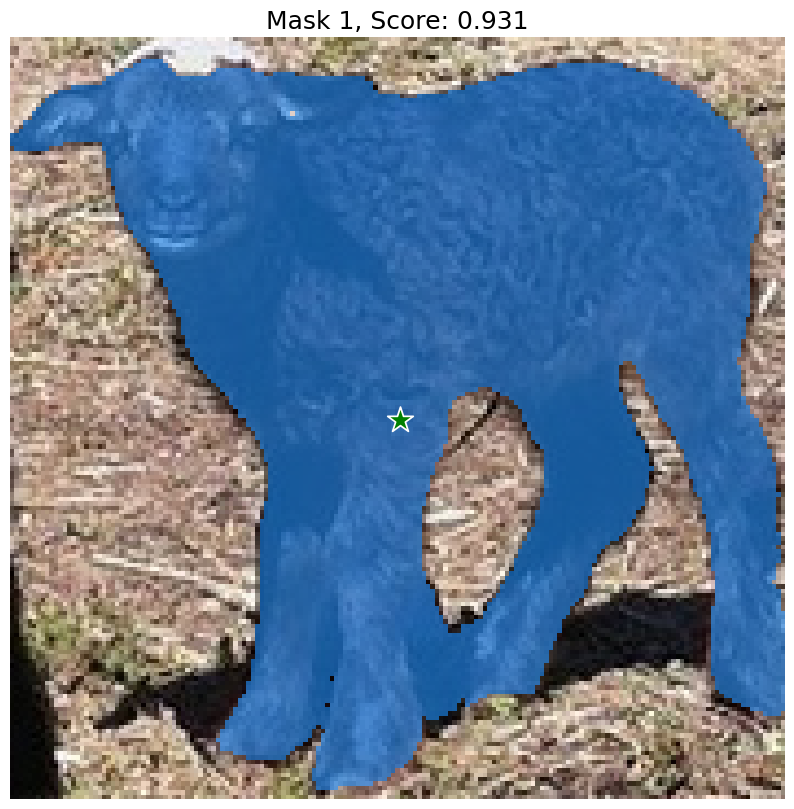

In [34]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(s_image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

In [35]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [36]:
s_image[~mask,:] = [255,255,255]

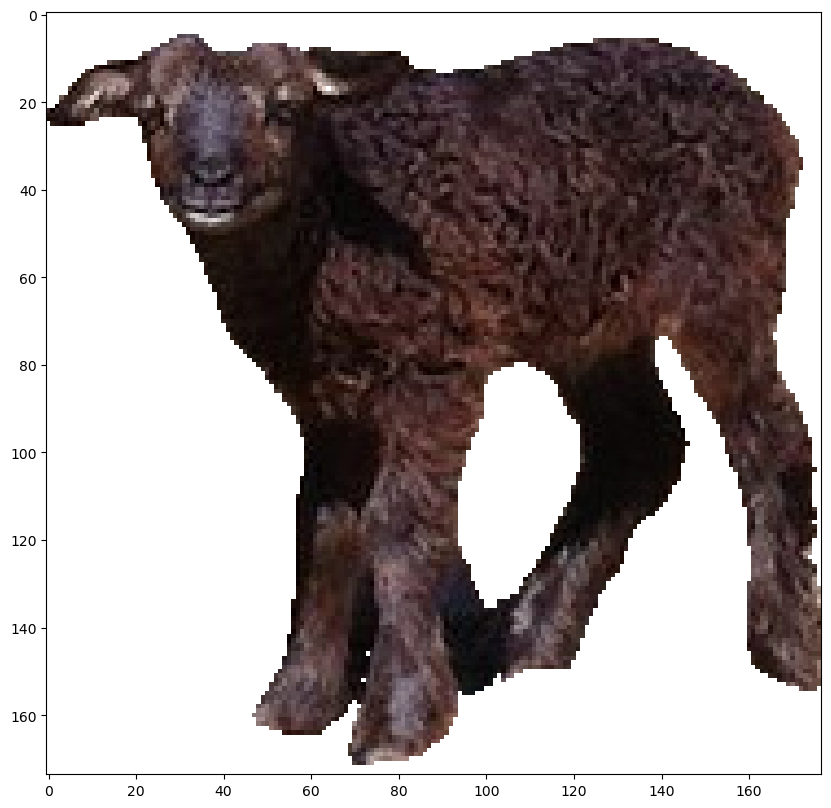

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(s_image)
plt.axis('on')
plt.show()

In [41]:
def image_prep_old(img_id, ann_id):
    
    #get image and bounding box
    img = refer.Imgs[img_id]
    bb = refer.Anns[ann_id]['bbox']
    fname = os.path.join(refer.IMAGE_DIR, img['file_name'])
    
    #load image 
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #apply bounding box to image
    bbox = refer.Anns[ann_id]['bbox']
    bbox = [int(b) for b in bbox]
    s_image = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]

    #load image into SAM
    if len(s_image) == 0: return None
    predictor.set_image(s_image)

    #find midpoint and create points to load into SAM
    x = s_image.shape[1]/2
    y = s_image.shape[0]/2
    input_point = np.array([[x, y], [x+s_image.shape[1]/4, y+ s_image.shape[0]/4], [x-s_image.shape[1]/4, y- s_image.shape[0]/4]])
    input_label = np.array([1,1,1])
    #'bbox': [x_min, y_min, width, height]
    #input_box = np.array([bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]) #xyxy format
    
    #get and apply mask
    masks, scores, _ = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)
    index_max = np.argmax(scores)
    s_image[~masks[index_max],:] = [255,255,255]
    
    #Display masks 
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(s_image)
        show_mask(mask, plt.gca())
        #show_box(input_box, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()
        
    #normalize image for processing
    xs = 224
    ys = 224
    if len(s_image) == 0: return None
    pim = PImage.fromarray(s_image)
    pim2 = pim.resize((xs,ys), PImage.Resampling.LANCZOS)
    img = np.array(pim2)
    
    if len(img.shape) < 3: return None
    
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    
    return pim

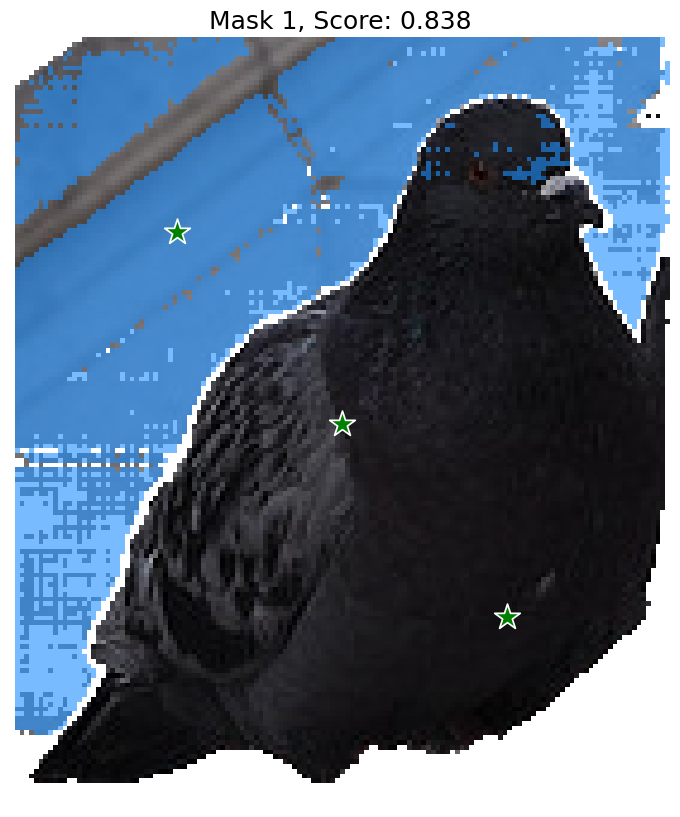

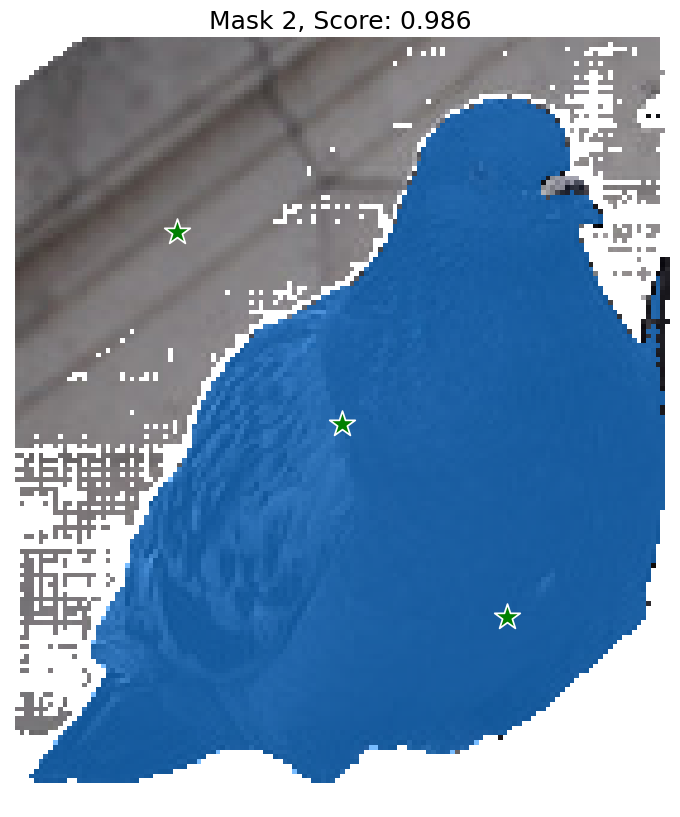

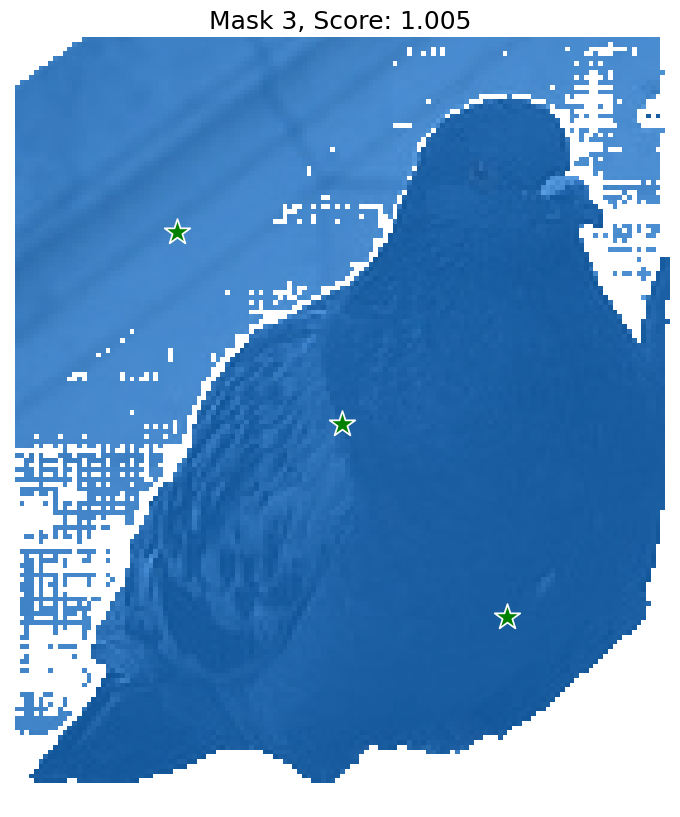

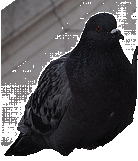

In [71]:
ref = refer.Refs[17]
image = image_prep_old(ref['image_id'], ref['ann_id'])
image

In [52]:
def image_prep_old2(img_id, ann_id):
    
    #get image and bounding box
    img = refer.Imgs[img_id]
    bb = refer.Anns[ann_id]['bbox']
    fname = os.path.join(refer.IMAGE_DIR, img['file_name'])
    
    #load image 
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #apply bounding box to image
    bbox = refer.Anns[ann_id]['bbox']
    bbox = [int(b) for b in bbox]
    s_image = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]

    #load image into SAM
    if len(s_image) == 0: return None
    predictor.set_image(s_image)

    #find midpoint and create points to load into SAM
    x = s_image.shape[1]/2
    y = s_image.shape[0]/2
    input_point = np.array([[x, y]])
    input_label = np.array([1])
    #'bbox': [x_min, y_min, width, height]
    #input_box = np.array([bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]) #xyxy format
    
    #get and apply mask
    masks, scores, _ = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)
    index_max = np.argmax(scores)
    #s_image[~masks[index_max],:] = [255,255,255]
    
    #Display masks 
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(s_image)
        show_mask(mask, plt.gca())
        #show_box(input_box, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()
        
    #normalize image for processing
    xs = 224
    ys = 224
    if len(s_image) == 0: return None
    pim = PImage.fromarray(s_image)
    pim2 = pim.resize((xs,ys), PImage.Resampling.LANCZOS)
    img = np.array(pim2)
    
    if len(img.shape) < 3: return None
    
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    
    return pim

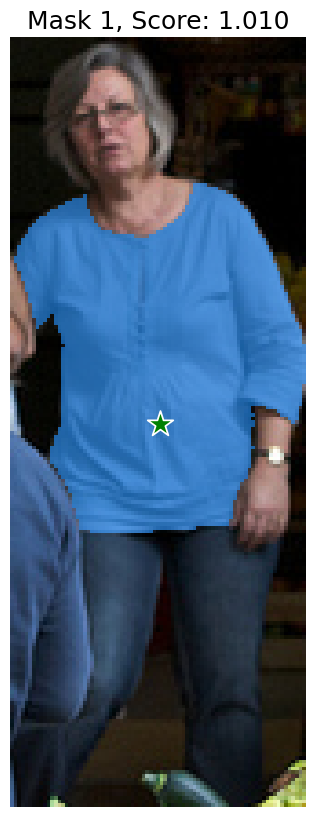

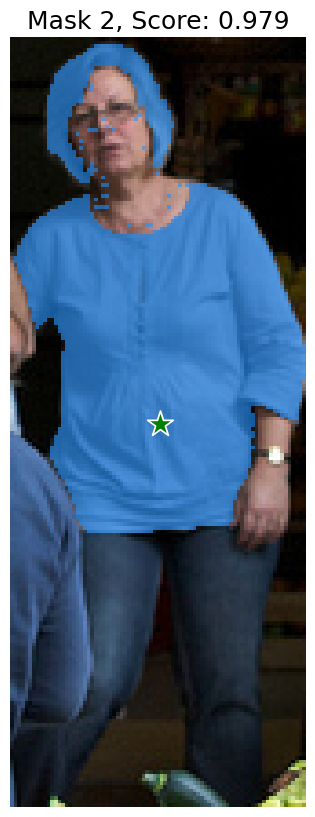

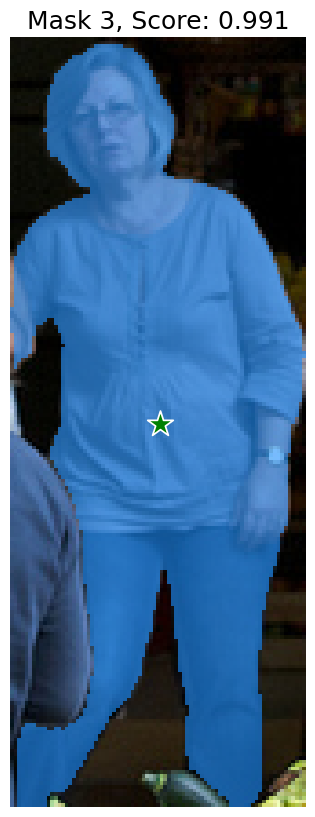

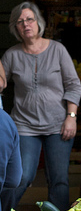

In [56]:
ref = refer.Refs[1]
image = image_prep_old2(ref['image_id'], ref['ann_id'])
image

1. woman in gray shirt facing camera on right
2. woman gray right
3. woman greyshirt right


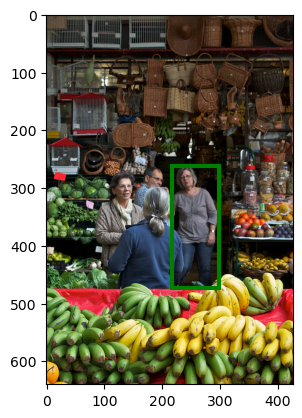

In [57]:
plt.figure()
refer.showRef(ref, seg_box='box')
plt.show()

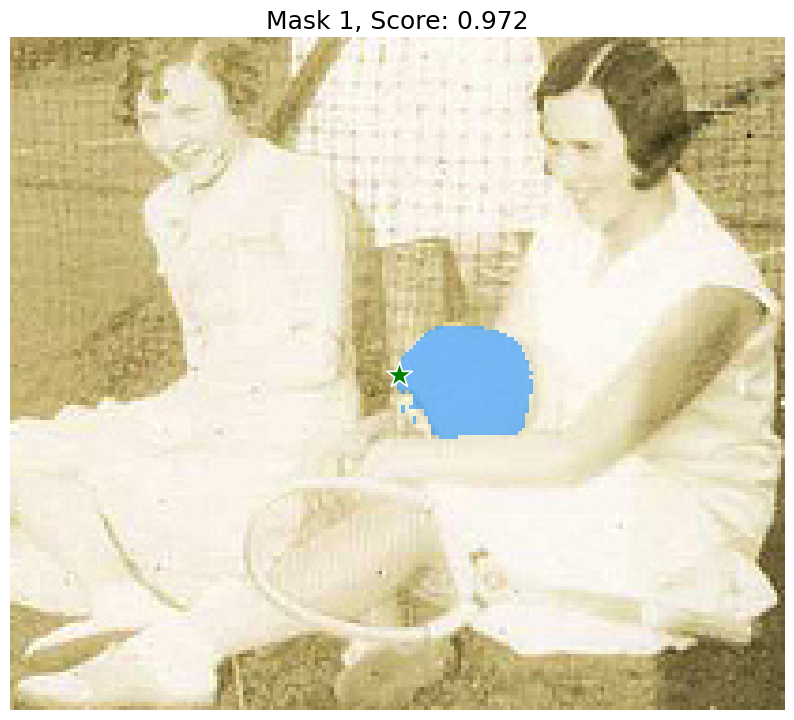

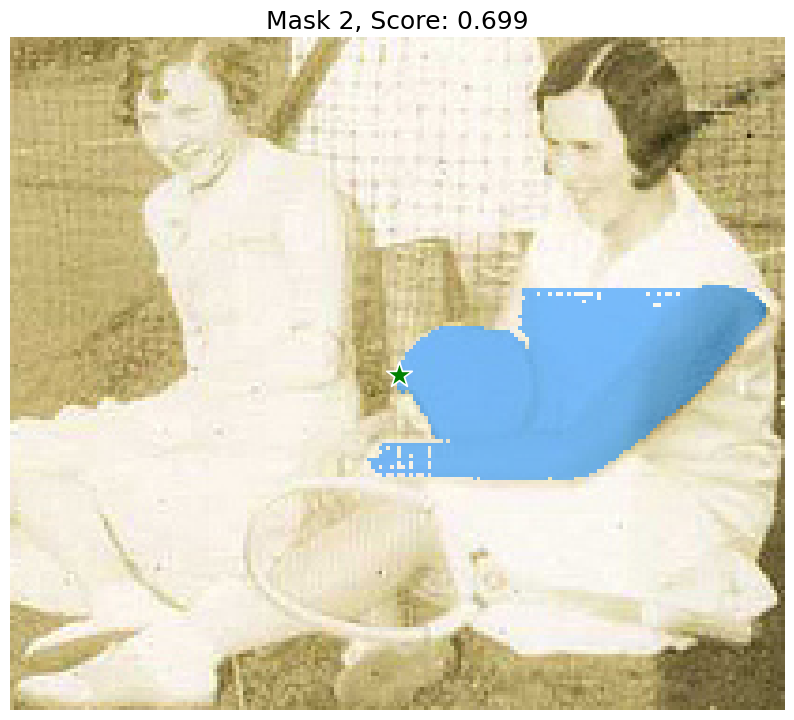

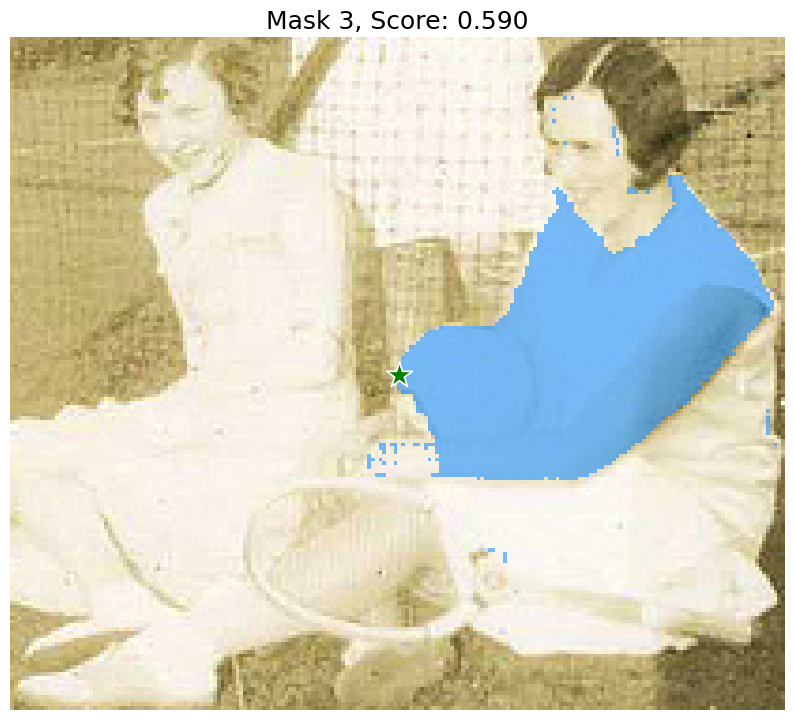

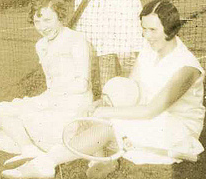

In [54]:
ref = refer.Refs[3]
image = image_prep_old2(ref['image_id'], ref['ann_id'])
image

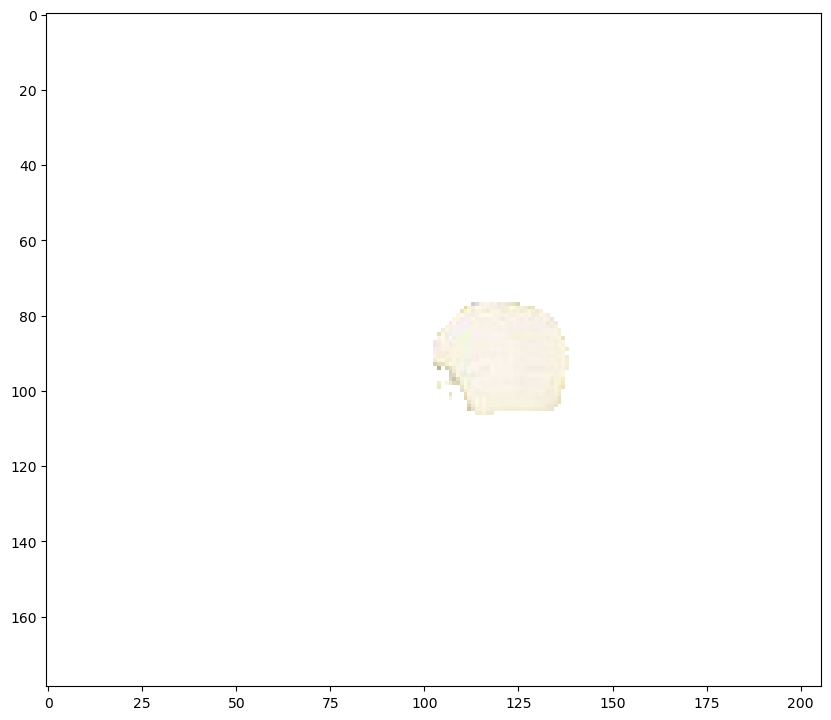

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

1. lady sitting on right
2. right girl on floor
3. woman sitting on right


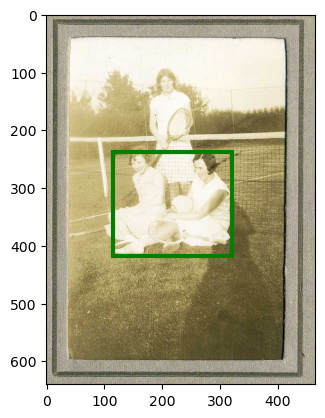

In [51]:
plt.figure()
refer.showRef(ref, seg_box='box')
plt.show()

In [72]:
def image_prep_large(img_id, ann_id):
    
    #get image and bounding box
    img = refer.Imgs[img_id]
    bb = refer.Anns[ann_id]['bbox']
    fname = os.path.join(refer.IMAGE_DIR, img['file_name'])
    
    #load image 
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #load image into SAM
    predictor.set_image(image)

    #find midpoint and create points to load into SAM
    bbox = refer.Anns[ann_id]['bbox']
    bbox = [int(b) for b in bbox]
    x = (bbox[0] + (bbox[2]/2))
    y = (bbox[1] + (bbox[3]/2))
    input_point = np.array([[x, y]])
    input_label = np.array([1])
    #bbox: [x_min, y_min, width, height]
    input_box = np.array([bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]) #xyxy format
    
    #get and apply mask
    masks, scores, _ = predictor.predict(point_coords=input_point, point_labels=input_label,  box=input_box, multimask_output=True)
    index_max = np.argmax(scores)
    image[~masks[index_max],:] = [255,255,255]
    
    #Display masks 
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        show_box(input_box, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()
        
    #normalize image for processing
    xs = 224
    ys = 224
    if len(image) == 0: return None
    pim = PImage.fromarray(image)
    pim2 = pim.resize((xs,ys), PImage.Resampling.LANCZOS)
    img = np.array(pim2)
    
    if len(img.shape) < 3: return None
    
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    
    return pim, img

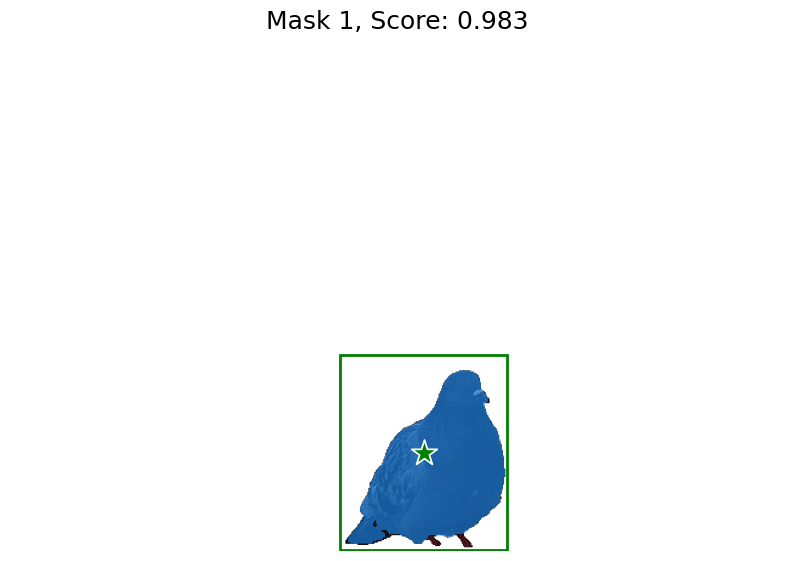

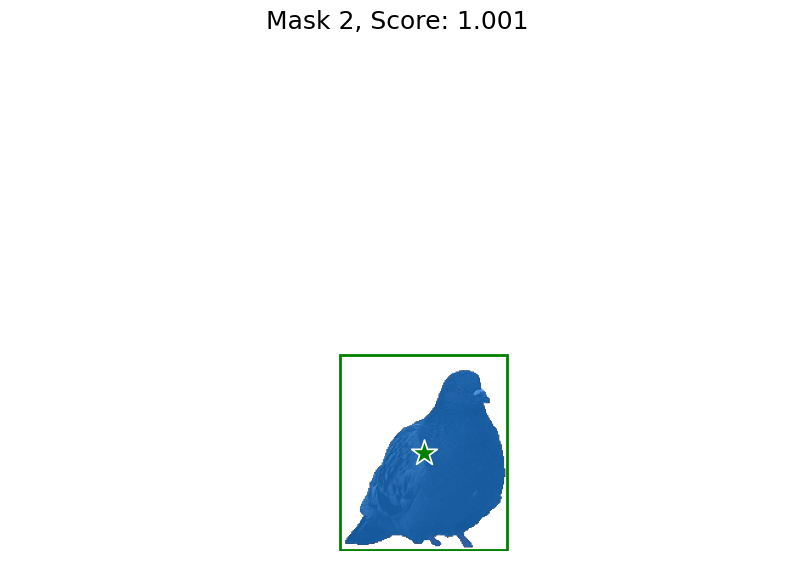

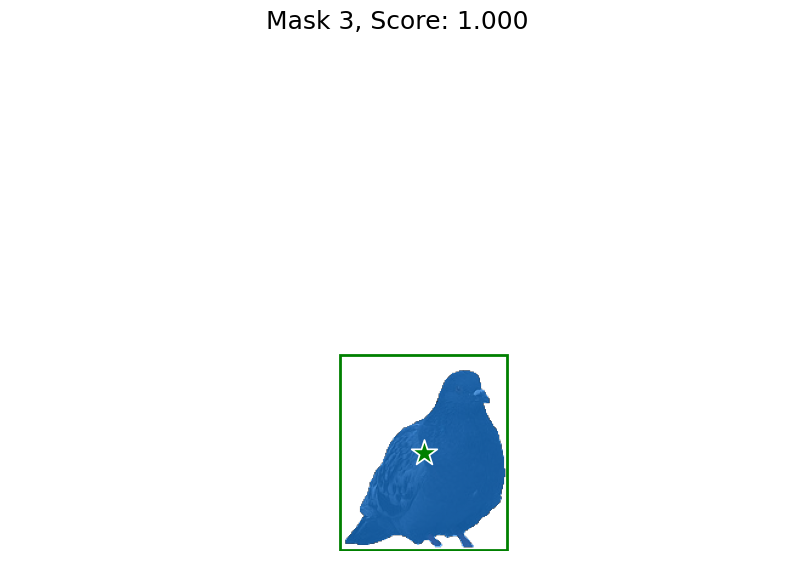

(<PIL.Image.Image image mode=RGB size=640x425>,
 array([[[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         ...,
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
         

In [74]:
ref = refer.Refs[17]
image = image_prep_large(ref['image_id'], ref['ann_id'])
image